In [20]:
import pandas as pd
import numpy as np
import os

In [4]:
data = pd.read_csv("data_with_photo_z.csv", low_memory=False, index_col=0)
data

,objID,run,ra,dec,rerun,camcol,field,z,zErr,template_photo_z,template_photo_zErr
0,1237645879551000764,94,348.841087,1.268802,301,6,93,0.399661,0.000078,0.378505,0.041041
1,1237645879562928805,94,16.026029,1.266772,301,6,275,0.752730,0.000267,0.679374,0.068663
2,1237645879573873373,94,41.019613,1.271279,301,6,442,0.504868,0.000213,0.487843,0.041076
3,1237645941824356668,109,40.277836,-0.777074,301,2,37,0.366744,0.000062,0.335330,0.085458
4,1237645941824357025,109,40.284751,-0.767711,301,2,37,0.626599,0.000152,0.613922,0.042154
...,...,...,...,...,...,...,...,...,...,...,...
93143,1237651737930104852,1458,238.611230,2.586243,301,6,760,0.386295,0.000089,0.357126,0.026436
93144,1237651737930105252,1458,238.716829,2.698187,301,6,760,0.225066,0.000035,0.218370,0.012380
93145,1237651737930105584,1458,238.729344,2.730604,301,6,760,0.597112,0.000156,0.561252,0.052941
93146,1237651737930105614,1458,238.737942,2.616392,301,6,760,0.475276,0.000103,0.521465,0.040119


In [5]:
from sdss_access import Path

sdss_path = Path(release="dr17")


In [6]:
data["file_name"] = data.apply(lambda row: sdss_path.url("frame", run=int(row['run']), rerun=int(row['rerun']), camcol=int(row['camcol']), field=int(row['field']), filter="x").split('/')[-1], axis=1)

In [49]:
# data

In [10]:
from astropy.io import fits
from astropy.io.fits.verify import VerifyWarning
from astropy.wcs import WCS, FITSFixedWarning
import warnings
warnings.simplefilter('ignore', (VerifyWarning, FITSFixedWarning))

In [44]:
def get_grid(filename, ra, dec, shape=(40, 40)):
    PATH = "eboss/photoObj/frames/301/94/6/"
    grids = []
    # for j in ["u", "g", "r", "i", "z"]:
    for j in ["r", "g", "u", "i", "z"]:
        current_band = filename.replace("frame-x-", f"frame-{j}-")
        with fits.open(f"{PATH}/{current_band}") as hdul:
            header = hdul[0].header
            data = hdul[0].data
            if "BSCALE" in header and "BZERO" in header:
                BSCALE = header["BSCALE"]
                BZERO = header["BZERO"]
                data = data * BSCALE + BZERO

        # Get the pixel coordinates for the given RA and Dec
        wcs = WCS(header)
        x, y = wcs.world_to_pixel_values(ra, dec)
        x = x.item() if hasattr(x, "item") else x
        y = y.item() if hasattr(y, "item") else y
        x, y = int(round(x)), int(round(y))

        # Define the grid boundaries
        height, width = shape
        xmin = max(0, x - width // 2)
        xmax = min(data.shape[1], x + width // 2)
        ymin = max(0, y - height // 2)
        ymax = min(data.shape[0], y + height // 2)

        # Extract the grid
        grid = data[ymin:ymax, xmin:xmax]

        # Determine the size of the grid to pad
        pad_y = max(0, height - (ymax - ymin))
        pad_x = max(0, width - (xmax - xmin))

        # Pad the grid to ensure it's 40x40
        padded_grid = np.pad(
            grid, ((0, pad_y), (0, pad_x)), mode="constant", constant_values=0
        )
        # Crop the padded grid to 40x40 if it exceeds the required size
        grid = padded_grid[:width, :height]

        grids.append(grid)
    return np.stack(grids, axis=-1).astype(np.float32)


def save_data(df, save_path="."):
    os.makedirs(f"{save_path}/X", exist_ok=True)
    os.makedirs(f"{save_path}/y", exist_ok=True)
    for i, row in df.iterrows():

        obj_id = row["objID"]
        file_name = row["file_name"]
        ra = row["ra"]
        dec = row["dec"]
        y = row[["z","zErr","template_photo_z","template_photo_zErr"]].astype(np.float32)
        grid = get_grid(row["file_name"], row["ra"], row["dec"])
        np.save(f"{save_path}/X/{obj_id}.npy", grid)
        np.save(f"{save_path}/y/{obj_id}.npy", y.values)
        break

In [45]:
save_data(data, save_path=".")

In [46]:
X = np.load("X/1237645879551000764.npy")
y = np.load("y/1237645879551000764.npy")

In [47]:
y

array([3.996609e-01, 7.808021e-05, 3.785050e-01, 4.104100e-02],
      dtype=float32)

In [48]:
np.allclose(data[["z","zErr","template_photo_z","template_photo_zErr"]].head(1).values, y)

True

In [12]:
ra, dec, filename = data["ra"][0].item(), data["dec"][0].item(), data["file_name"][0]
grid = get_grid(filename, ra, dec, (40, 40))

In [13]:
grid.shape

(40, 40, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15161133..0.47216797].


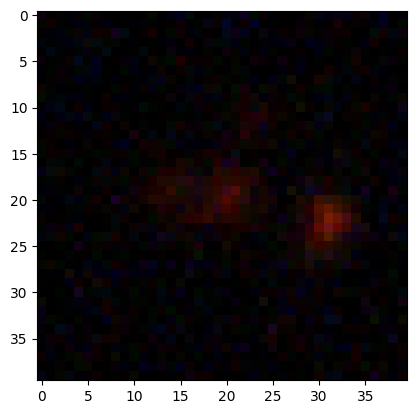

In [14]:
from matplotlib import pyplot as plt
plt.imshow(get_grid(filename, ra, dec, (40, 40))[:, :, 0:3], interpolation='nearest')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19482422..77.125].


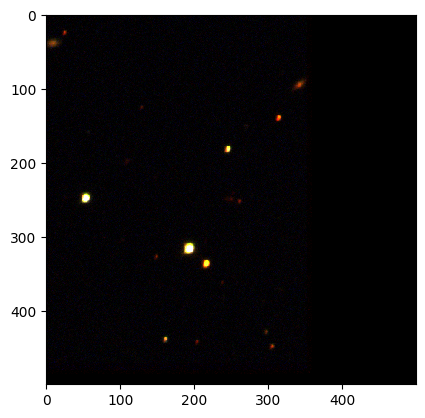

In [15]:
from matplotlib import pyplot as plt
plt.imshow(get_grid(filename, ra, dec, (500, 500))[:, :, 0:3], interpolation='nearest')
plt.show()

In [56]:
data.head(1).loc[data.head(1).index.repeat(2000)].to_csv("speed_test_data.csv")